# Exploratory Data Analysis

### Objective

In this notebook I familiarize myself with the data. This includes cleaning and restructuring the data in a way that suits the project's machine learning-based goal. Throughout the course of this notebook I inspect the different variables in the data to understand them and also get a sense of if and how they'll factor into my modeling.


### Data Dictionary

"The dataset contains data about user sessions that have been recorded over a period of
time. The dataset consists of two parts: the training dataset where user ID's are labeled, and
the verification set without labels.
Each session is represented by a JSON object with the following fields:

- "user_id" is the unique identifier of the user.
- "browser", "os", "locale" contain info about the software on the user's machine.
- "gender", "location" give analytics data about the user.
- "date" and "time" is the moment when the session started (in GMT).
- "sites" is a list of up to 15 sites visited during the session. For each site, the URL and the length of visit in seconds are given."

Imports

In [2]:
import pandas as pd
import numpy as np
import json
import joblib
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from sklearn.feature_extraction.text import CountVectorizer

#utililty helper functions I made to aide with plotting
from utils import histogram_boxplot, labeled_barplot, distribution_plot_wrt_target, crosstab_plot, custom_vect

In [3]:
#Load in data
path = "../data/dataset.json"
with open(path) as f:
    data = json.load(f)


Inspect first element.

In [4]:
data[0]

{'browser': 'Chrome',
 'os': 'Windows 8',
 'locale': 'de-DE',
 'user_id': 164,
 'gender': 'm',
 'location': 'Canada/Toronto',
 'sites': [{'site': 'lenta.ru', 'length': 296},
  {'site': 'lenta.ru', 'length': 69},
  {'site': 'vk.com', 'length': 94},
  {'site': 'lenta.ru', 'length': 129},
  {'site': 'wikipedia.org', 'length': 70},
  {'site': 'instagram.com', 'length': 120},
  {'site': 'msn.com', 'length': 54},
  {'site': 'amazon.com', 'length': 213},
  {'site': 'outlook.com', 'length': 140},
  {'site': 'verisign.com', 'length': 166},
  {'site': 'googleadservices.com', 'length': 115},
  {'site': 'akamaiedge.net', 'length': 88},
  {'site': 'stardock.com', 'length': 207},
  {'site': 'mediaarea.net', 'length': 78}],
 'time': '03:57:00',
 'date': '2016-08-14'}

Convert to pandas dataframe

In [5]:
df = pd.json_normalize(data)
df.head()

,browser,os,locale,user_id,gender,location,sites,time,date
0,Chrome,Windows 8,de-DE,164,m,Canada/Toronto,"[{'site': 'lenta.ru', 'length': 296}, {'site':...",03:57:00,2016-08-14
1,Chrome,Windows 10,pt-PT,99,f,Netherlands/Amsterdam,"[{'site': 'windowsupdate.com', 'length': 56}, ...",13:52:00,2016-05-31
2,Chrome,Windows 10,bg-BG,28,m,Brazil/Rio de Janeiro,"[{'site': 'slack.com', 'length': 158}, {'site'...",17:40:00,2019-04-15
3,Internet Explorer,Ubuntu,en-US,163,f,New Zealand/Auckland,"[{'site': 'amazon.com', 'length': 168}, {'site...",20:23:00,2018-03-25
4,Firefox,Debian,ro-RO,177,f,New Zealand/Auckland,"[{'site': 'vk.com', 'length': 43}, {'site': 'm...",01:10:00,2018-09-08


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160000 entries, 0 to 159999
Data columns (total 9 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   browser   160000 non-null  object
 1   os        160000 non-null  object
 2   locale    160000 non-null  object
 3   user_id   160000 non-null  int64 
 4   gender    160000 non-null  object
 5   location  160000 non-null  object
 6   sites     160000 non-null  object
 7   time      160000 non-null  object
 8   date      160000 non-null  object
dtypes: int64(1), object(8)
memory usage: 11.0+ MB


We have 160000 rows and 9 columns. More importantly, we see that there are no null values

I create a new column called `target` which comes from transforming the `user_id` column into 1 representing joe sessions and 0 representing non joe sessions.

In [7]:
df["target"] = (df.user_id==0)*1

In [8]:
df.target.value_counts()

0    159200
1       800
Name: target, dtype: int64

In [9]:
df.target.value_counts(normalize=True)

0    0.995
1    0.005
Name: target, dtype: float64

Here we have a highly imbalanced class dataset, where only 1 in 200 datapoints belong to the true class.

Drop `user_id`

In [10]:
df.drop("user_id", axis = 1, inplace=True)

In [11]:
df.head()

,browser,os,locale,gender,location,sites,time,date,target
0,Chrome,Windows 8,de-DE,m,Canada/Toronto,"[{'site': 'lenta.ru', 'length': 296}, {'site':...",03:57:00,2016-08-14,0
1,Chrome,Windows 10,pt-PT,f,Netherlands/Amsterdam,"[{'site': 'windowsupdate.com', 'length': 56}, ...",13:52:00,2016-05-31,0
2,Chrome,Windows 10,bg-BG,m,Brazil/Rio de Janeiro,"[{'site': 'slack.com', 'length': 158}, {'site'...",17:40:00,2019-04-15,0
3,Internet Explorer,Ubuntu,en-US,f,New Zealand/Auckland,"[{'site': 'amazon.com', 'length': 168}, {'site...",20:23:00,2018-03-25,0
4,Firefox,Debian,ro-RO,f,New Zealand/Auckland,"[{'site': 'vk.com', 'length': 43}, {'site': 'm...",01:10:00,2018-09-08,0


Next up I inspect each of the features. My process involves looking structure of the data, visualizing distributions, and understanding the cardinality of discrete features.

### Sites

Due to the nested element of the `sites`, this collection of valuable information requires extensive data wrangling.

In [12]:
sites = df["sites"]
sites

0         [{'site': 'lenta.ru', 'length': 296}, {'site':...
1         [{'site': 'windowsupdate.com', 'length': 56}, ...
2         [{'site': 'slack.com', 'length': 158}, {'site'...
3         [{'site': 'amazon.com', 'length': 168}, {'site...
4         [{'site': 'vk.com', 'length': 43}, {'site': 'm...
                                ...                        
159995    [{'site': 'amazon.com', 'length': 54}, {'site'...
159996    [{'site': 'microsoft.com', 'length': 278}, {'s...
159997    [{'site': 'googleapis.com', 'length': 86}, {'s...
159998    [{'site': 'live.com', 'length': 145}, {'site':...
159999    [{'site': 'amazon.com', 'length': 89}, {'site'...
Name: sites, Length: 160000, dtype: object

My goal here is to create a matrix where columns represent websites, rows are sessions, and the values are the time spent at that site for that session.

I decided that the best way to do accomplish this task was to treat the array as if I was making a document term matrix from raw text.

I use `custom_vect` function I imported from from utils.py to format the nested array data so it can't be vectorized.


This is effectively what the `custom_vect` function does. The frequency of the website name in each row is determined by the number of seconds spent on the site.

In [13]:
sites.iloc[:10].apply(custom_vect)

0    [lenta.ru, lenta.ru, lenta.ru, lenta.ru, lenta...
1    [windowsupdate.com, windowsupdate.com, windows...
2    [slack.com, slack.com, slack.com, slack.com, s...
3    [amazon.com, amazon.com, amazon.com, amazon.co...
4    [vk.com, vk.com, vk.com, vk.com, vk.com, vk.co...
5    [netflix.net, netflix.net, netflix.net, netfli...
6    [google.com, google.com, google.com, google.co...
7    [vk.com, vk.com, vk.com, vk.com, vk.com, vk.co...
8    [digicert.com, digicert.com, digicert.com, dig...
9    [scorecardresearch.com, scorecardresearch.com,...
Name: sites, dtype: object

How many websites are there in total?

In [30]:
n_sites = set()

In [31]:
for i in range(len(sites)):
    row = sites.iloc[i]
    
    for e in row:
        n_sites.add(e["site"])

In [32]:
len(n_sites)

157771

157771 sites provides a scalability and dimensionality issue so I think it's best to keep the top 1000 most visited websites. So I'd like to calculate what percent of the total time spent visiting websites belongs to the top 1000.

In [34]:
#Dictionary to hold sites and the total visit time spent.
site_time = defaultdict(int)

for i in range(len(sites)):
    row = sites.iloc[i]
    
    for e in row:
        sit = e["site"]
        leng = e["length"]
        site_time[sit] += leng
        
#Convert to series
site_time = pd.Series(site_time)

#Calculate percent of total time belonging to top 1000
site_time.nlargest(1000).sum()/site_time.sum()

0.8608227790119717

86.1% of total time spent visting websites belongs to the top 1000 most frequented websites. Based on this, I think it's sufficient to stick to these 1000 sites when restructing the `sites` data.

Here I set up the `CountVectorizer` to restructure the `sites` data.

In [35]:
cv = CountVectorizer(analyzer=custom_vect, max_features=1000)
sites_enc = cv.fit_transform(sites)
sites_enc = pd.DataFrame(sites_enc.toarray(), columns=cv.get_feature_names())
sites_enc

,0x.tf,139.com,22.cn,247wallst.com,28s06.xyz,32degrees.com,4digitalsignage.com,4icu.org,4shared.com,7xxgq.xyz,...,yupptv.io,ziffstatic.com,zmedia.vn,zomatobook.com,zoomg.ir,zoozoosexporn.com,zradio.org,zscalergov.net,zubuchygri.com,zuuks.com
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
159996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
159997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
159998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Save the `CountVectorizer` object to the `models` directory so that it can be used to transform the validation data.

In [36]:
joblib.dump(cv, "../model/countvec.joblib")

['../model/countvec.joblib']

The newly created `sites_enc` data can be now be used to train a machine learning model.

The top 20 most visited sites. 

In [37]:
most_viewed_sites = sites_enc.sum()
most_viewed_sites.nlargest(20)

amazon.com               19899832
wikipedia.org            19582538
vk.com                    7321567
mail.google.com           5838751
youtube.com               5835843
lenta.ru                  5753531
slack.com                 5741614
toptal.com                4871228
netflix.com               4177459
scorecardresearch.com     4017629
msn.com                   3985468
facebook.com              3960248
nflxso.net                3944517
icloud.com                3840726
verisign.com              3831966
twitter.com               3797960
akamaiedge.net            3722344
airbnb.com                3707828
skyscanner.com            3641410
googleadservices.com      3492801
dtype: int64

Create a new column that holds the average session length per site per session for the purpose of analyzing the relationship between session length and the target variable.

In [38]:
total_length = sites_enc.sum(axis = 1)
avg_length = total_length/(sites_enc>0).sum(axis = 1)
avg_length

0         155.400000
1         119.166667
2         114.200000
3          98.000000
4          95.300000
             ...    
159995    107.727273
159996    176.166667
159997    135.727273
159998    126.250000
159999    133.090909
Length: 160000, dtype: float64

In [39]:
#add avg_length to data
df["avg_length"] = avg_length

In [40]:
#remove sites
df.drop("sites", axis = 1, inplace = True)

In [41]:
df.head()

,browser,os,locale,gender,location,time,date,target,avg_length
0,Chrome,Windows 8,de-DE,m,Canada/Toronto,03:57:00,2016-08-14,0,155.400000
1,Chrome,Windows 10,pt-PT,f,Netherlands/Amsterdam,13:52:00,2016-05-31,0,119.166667
2,Chrome,Windows 10,bg-BG,m,Brazil/Rio de Janeiro,17:40:00,2019-04-15,0,114.200000
3,Internet Explorer,Ubuntu,en-US,f,New Zealand/Auckland,20:23:00,2018-03-25,0,98.000000
4,Firefox,Debian,ro-RO,f,New Zealand/Auckland,01:10:00,2018-09-08,0,95.300000


Visualize the distribution of `avg_length`

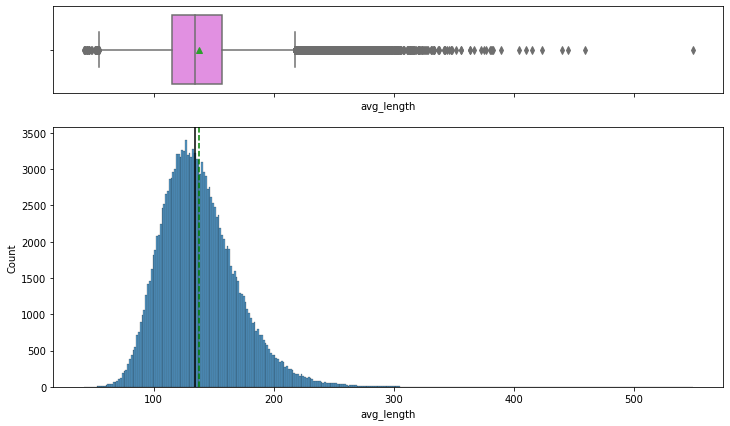

In [42]:
histogram_boxplot(df, "avg_length")

Data shows a normal distribution, with the majority of sessions visiting each site for on average between 100 and 200 seconds.

### Browser

In [23]:
df.browser.value_counts()

Chrome               83544
Firefox              34442
Safari               28381
Internet Explorer    13633
Name: browser, dtype: int64

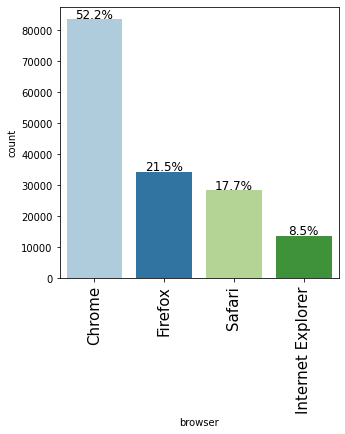

In [21]:
labeled_barplot(df, "browser", perc = True)

Slight majority of sessions used a Chrome as their browser.

### OS

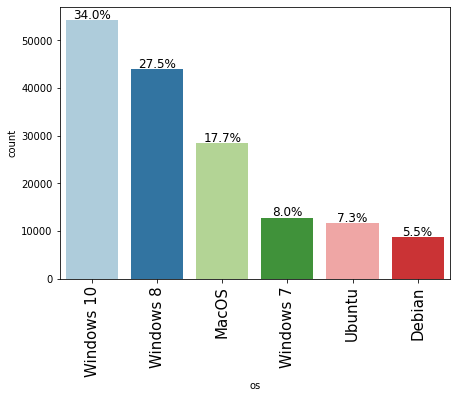

In [43]:
labeled_barplot(df, "os", perc = True)

Windows is the dominant OS here, representing almost 70% of the sessions.

### Locale

In [44]:
df.locale.head()

0    de-DE
1    pt-PT
2    bg-BG
3    en-US
4    ro-RO
Name: locale, dtype: object

For locale I split up the variables by separating the codes representing language from country

In [45]:
df["software_language"] = df.locale.apply(lambda x:x[:2])
df.software_language.value_counts()

en    41949
ru    16402
pt    14809
bg    14375
nl    10836
de    10473
ja     9571
ro     8869
fr     8026
it     6693
es     6428
pl     6372
uk     5197
Name: software_language, dtype: int64

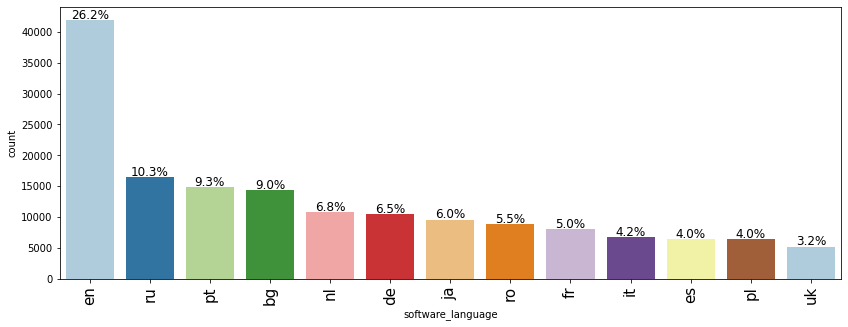

In [46]:
labeled_barplot(df, "software_language", perc = True)

English holds a plurality of software language used in sessions.

In [47]:
df['software_country'] = df.locale.apply(lambda x:x[-2:])
df.software_country.value_counts()

RU    16402
BG    14375
NL    10836
DE    10473
SG    10047
JP     9571
RO     8869
CA     8745
FR     8026
NZ     7588
PT     7509
BR     7300
GB     6795
IT     6693
MX     6428
US     6392
PL     6372
UA     5197
AU     2382
Name: software_country, dtype: int64

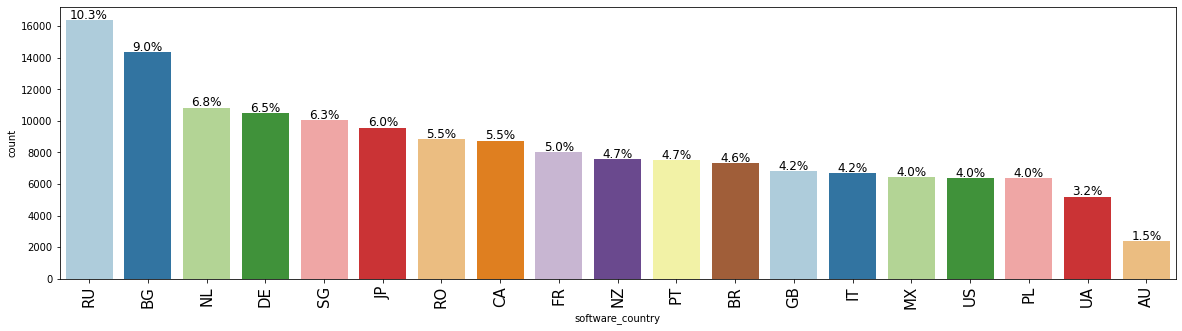

In [48]:
labeled_barplot(df, "software_country", perc = True)

The `software_country` variable fairly evenly distributed, with the largest amount (Russia) comprising 10.3% of the sessions.

Drop `locale` variable

In [49]:
df.drop("locale", axis = 1, inplace=True)

In [50]:
df.head()

,browser,os,gender,location,time,date,target,avg_length,software_language,software_country
0,Chrome,Windows 8,m,Canada/Toronto,03:57:00,2016-08-14,0,155.400000,de,DE
1,Chrome,Windows 10,f,Netherlands/Amsterdam,13:52:00,2016-05-31,0,119.166667,pt,PT
2,Chrome,Windows 10,m,Brazil/Rio de Janeiro,17:40:00,2019-04-15,0,114.200000,bg,BG
3,Internet Explorer,Ubuntu,f,New Zealand/Auckland,20:23:00,2018-03-25,0,98.000000,en,US
4,Firefox,Debian,f,New Zealand/Auckland,01:10:00,2018-09-08,0,95.300000,ro,RO


### Gender

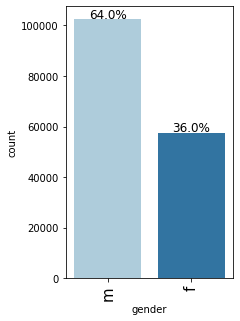

In [51]:
labeled_barplot(df, "gender", perc = True)

A gender ratio of almost 2:1 between men and women.

### Location

In [52]:
df["location"]

0                Canada/Toronto
1         Netherlands/Amsterdam
2         Brazil/Rio de Janeiro
3          New Zealand/Auckland
4          New Zealand/Auckland
                  ...          
159995           China/Shanghai
159996     New Zealand/Auckland
159997            Russia/Moscow
159998               Italy/Rome
159999    Netherlands/Amsterdam
Name: location, Length: 160000, dtype: object

I split up the `location` variable into `country` and `city`

In [53]:
df["country"] = df.location.apply(lambda x:x.split('/')[0])
df["city"] = df.location.apply(lambda x:x.split('/')[1])

In [54]:
df.head()

,browser,os,gender,location,time,date,target,avg_length,software_language,software_country,country,city
0,Chrome,Windows 8,m,Canada/Toronto,03:57:00,2016-08-14,0,155.400000,de,DE,Canada,Toronto
1,Chrome,Windows 10,f,Netherlands/Amsterdam,13:52:00,2016-05-31,0,119.166667,pt,PT,Netherlands,Amsterdam
2,Chrome,Windows 10,m,Brazil/Rio de Janeiro,17:40:00,2019-04-15,0,114.200000,bg,BG,Brazil,Rio de Janeiro
3,Internet Explorer,Ubuntu,f,New Zealand/Auckland,20:23:00,2018-03-25,0,98.000000,en,US,New Zealand,Auckland
4,Firefox,Debian,f,New Zealand/Auckland,01:10:00,2018-09-08,0,95.300000,ro,RO,New Zealand,Auckland


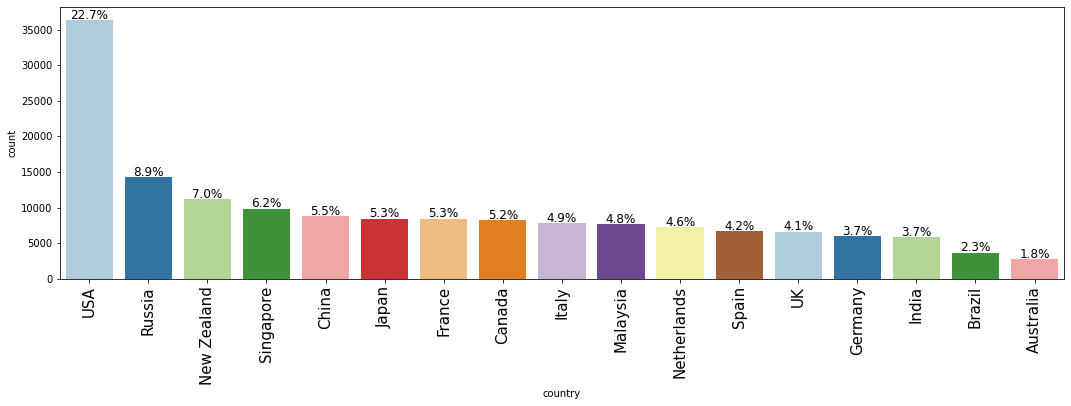

In [55]:
labeled_barplot(df, "country", perc=True)

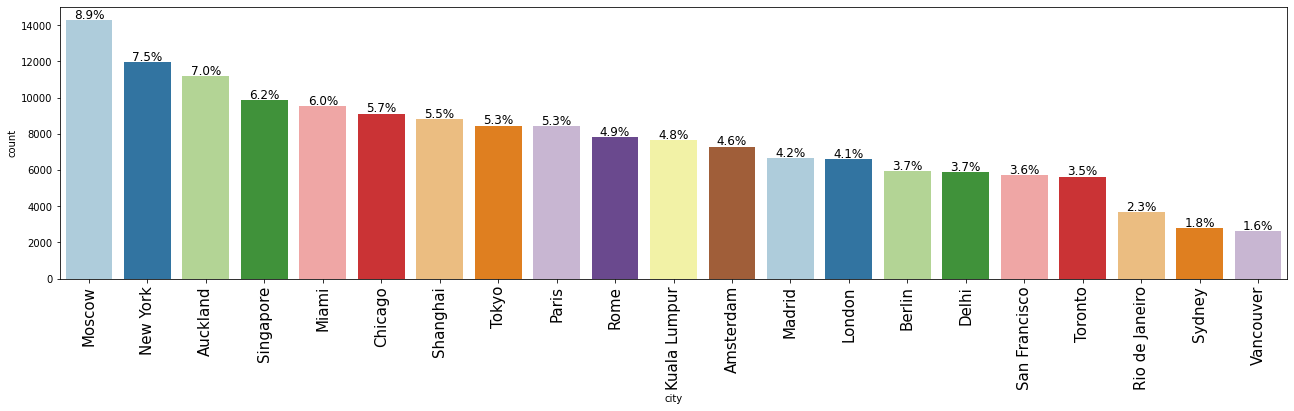

In [56]:
labeled_barplot(df, "city", perc = True)

In [57]:
#drop location
df.drop("location", axis = 1, inplace=True)

### Time

In [58]:
df.time.dtype

dtype('O')

In [59]:
df.time.apply(lambda x:x[-2:]).unique()

array(['00'], dtype=object)

All time values have 00 second marks.

In [60]:
df.time.value_counts()

03:00:00    1339
05:00:00    1243
04:00:00     925
07:00:00     889
09:00:00     622
            ... 
22:17:00      60
22:05:00      59
22:20:00      59
20:07:00      59
20:21:00      51
Name: time, Length: 1440, dtype: int64

Grab the hour from the `time` variable

In [61]:
df["hour"] = df.time.apply(lambda x:int(x[:2]))

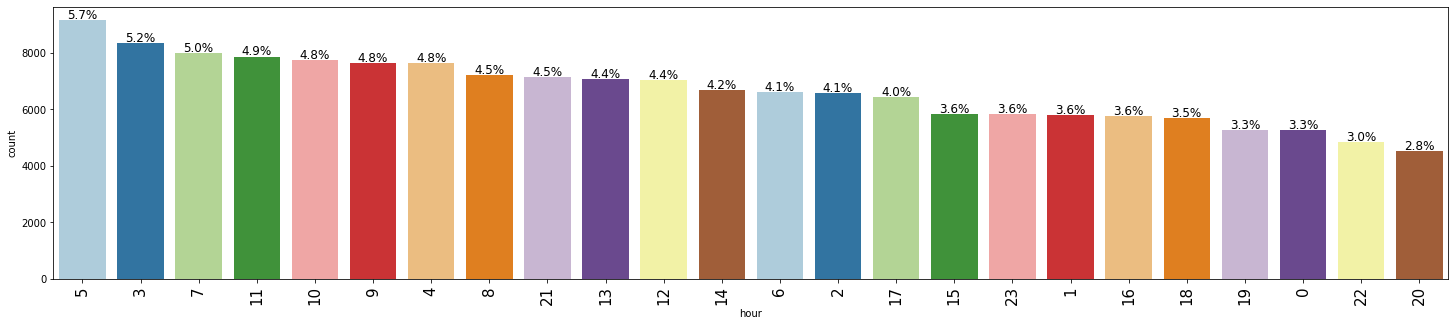

In [62]:
labeled_barplot(df, 'hour', perc=True)

There doesn't appear to be much variation of the hours at which sessions occur.

In [63]:
df.head()

,browser,os,gender,time,date,target,avg_length,software_language,software_country,country,city,hour
0,Chrome,Windows 8,m,03:57:00,2016-08-14,0,155.400000,de,DE,Canada,Toronto,3
1,Chrome,Windows 10,f,13:52:00,2016-05-31,0,119.166667,pt,PT,Netherlands,Amsterdam,13
2,Chrome,Windows 10,m,17:40:00,2019-04-15,0,114.200000,bg,BG,Brazil,Rio de Janeiro,17
3,Internet Explorer,Ubuntu,f,20:23:00,2018-03-25,0,98.000000,en,US,New Zealand,Auckland,20
4,Firefox,Debian,f,01:10:00,2018-09-08,0,95.300000,ro,RO,New Zealand,Auckland,1


### date

Conver the `date` column into a datetime object

In [64]:
df["date"] = pd.to_datetime(df["date"])
df.date

0        2016-08-14
1        2016-05-31
2        2019-04-15
3        2018-03-25
4        2018-09-08
            ...    
159995   2018-10-15
159996   2016-03-23
159997   2019-03-03
159998   2016-12-14
159999   2016-12-04
Name: date, Length: 160000, dtype: datetime64[ns]

Create a new variable called `weekday`.

In [65]:
df["weekday"] = (df.date.dt.weekday < 5)*1

Visualize the rate of sessions per month over the course of the data.

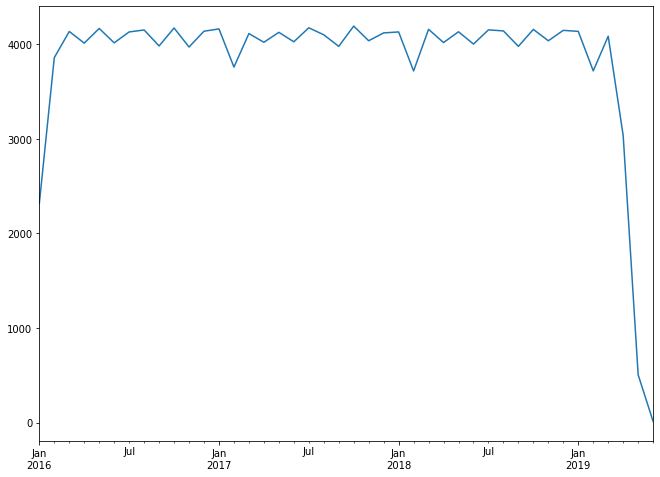

In [66]:
dates = pd.Series(index=df.date.values, data = np.ones(shape=df.shape[0]))
monthly = dates.resample("m").sum()
monthly.plot(figsize=(11, 8));

A cursory look at the data shows that outside of the beginning and end months, the rate of sessions has been consistent.

## Bivariate Analysis

In this section, I examine the relationship between various pairs of variables with a focus on the relationships between the target and features.

The `distribution_plot_wrt_target` function plots boxplots and histograms for a specific quantitative variable grouped by the groups of a categorical variable.

###  Avg_length vs target

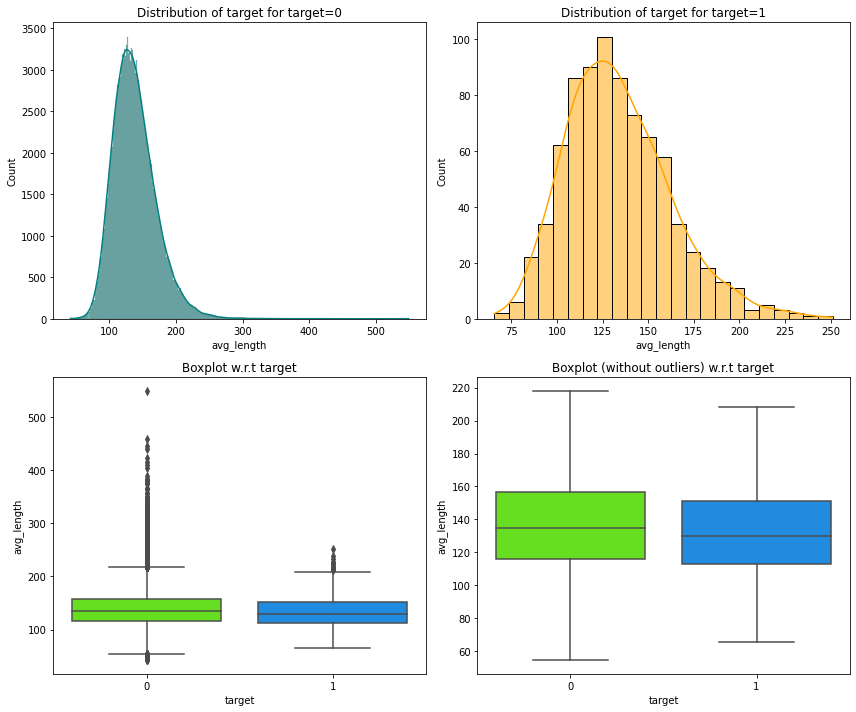

In [67]:
distribution_plot_wrt_target(df, "avg_length", 'target')

It does not appear that there is a substantial difference of the average length of sessions for joe and not joe sessions.

###  hour vs target

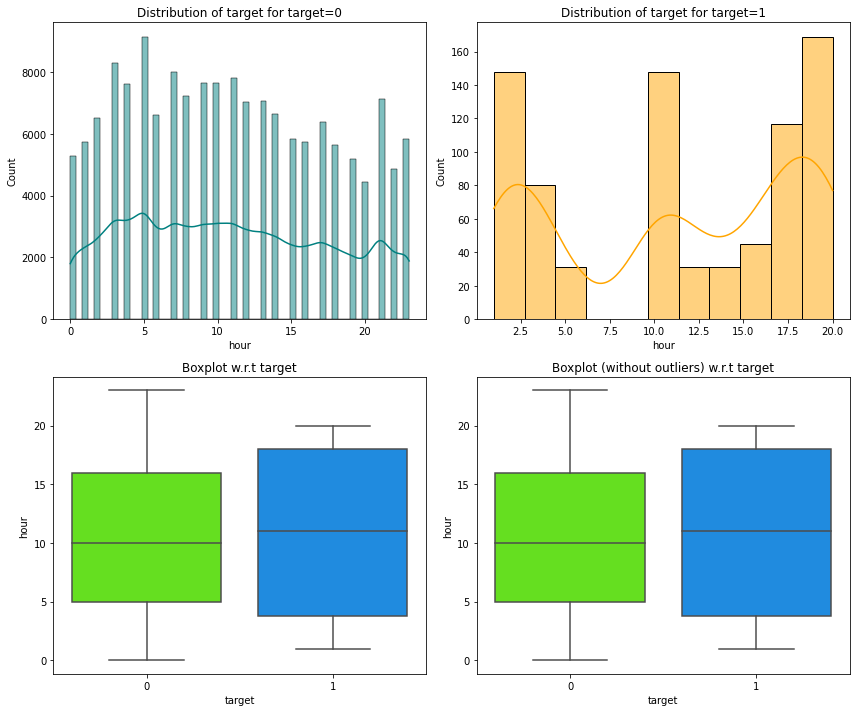

In [68]:
distribution_plot_wrt_target(df, "hour", 'target')

From here we see that the average time of day of sessions does not significantly differ between joe and not joe sessions.

### browser vs target

I use the `crosstab_plot` function to analyze the relationship between two different categorical variables.

The following plot shows what the percentage of sessions that are joe for each of the values in the browser column. The vertical red line shows the overall percentage of the data that is marked as joe.

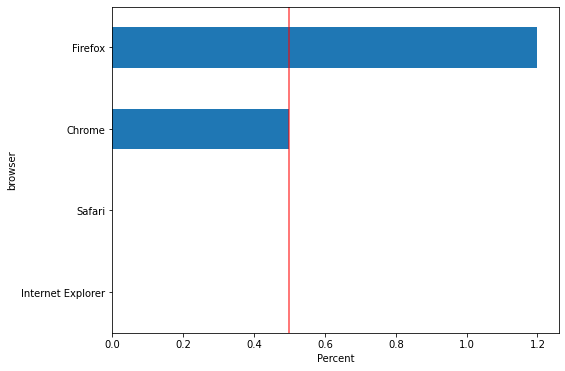

In [69]:
crosstab_plot(df, 'browser', 'target')

From this plot we see that the Firefox is disproportionately used more often in joe sessions compared to the other three. Safari and Internet Explorer aren't even used once for joe sessions where Chrome sessions match the general population.

### OS vs target

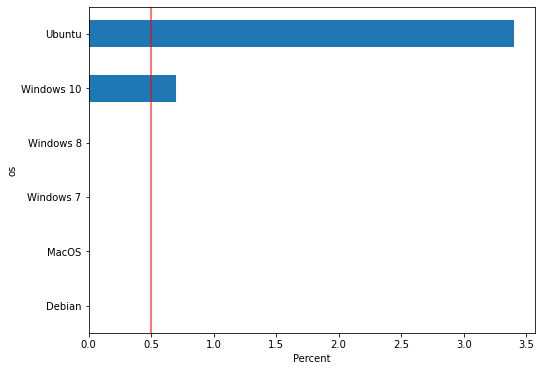

In [70]:
crosstab_plot(df, 'os', 'target')

Joe sessions only use either Ubuntu or Windows 10 operating systems. Joe sessions accounts for almost 3.5% of all Ubuntu sessions.

### gender vs target

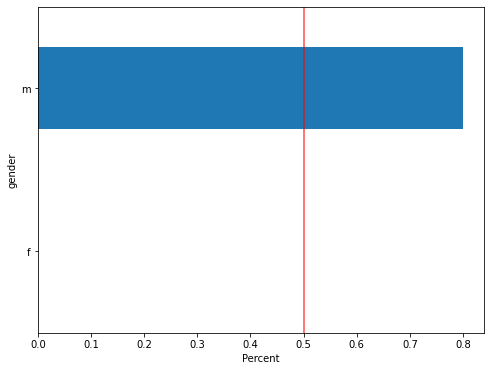

In [71]:
crosstab_plot(df, 'gender', 'target')

We learn here that Joe is a male and therefore that a sessions from a female guarantees that that session isn't Joe.

### country and city vs target

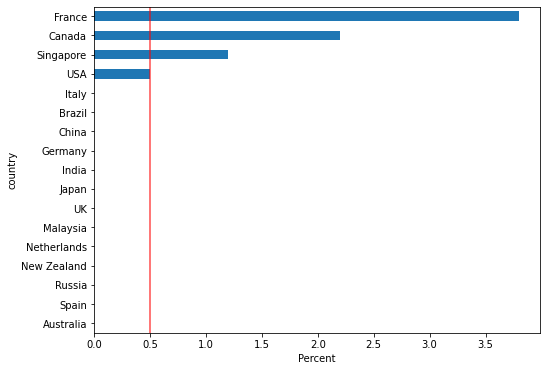

In [72]:
crosstab_plot(df, 'country', 'target')

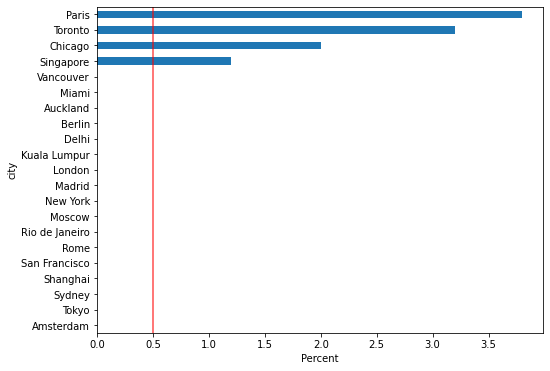

In [73]:
crosstab_plot(df, 'city', 'target')

Joe sessions only occur in only four cities, in addition this plot tells us that we don't need both columns.

### software vs target

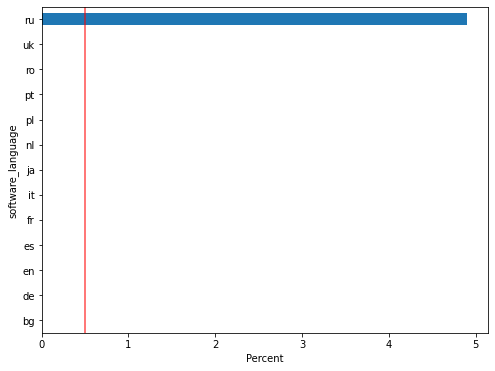

In [74]:
crosstab_plot(df, 'software_language', 'target')

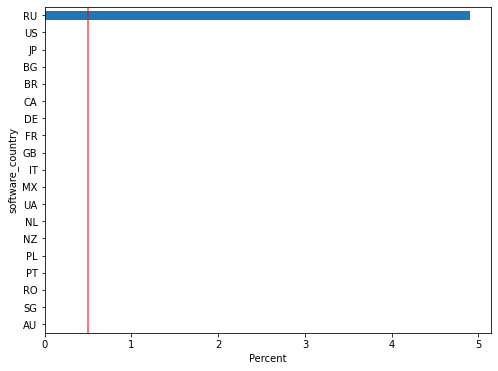

In [75]:
crosstab_plot(df, 'software_country', 'target')

In [76]:
pd.crosstab(df.software_country, df.software_language)

software_language,bg,de,en,es,fr,it,ja,nl,pl,pt,ro,ru,uk
software_country,,,,,,,,,,,,,
AU,0,0,2382,0,0,0,0,0,0,0,0,0,0
BG,14375,0,0,0,0,0,0,0,0,0,0,0,0
BR,0,0,0,0,0,0,0,0,0,7300,0,0,0
CA,0,0,8745,0,0,0,0,0,0,0,0,0,0
DE,0,10473,0,0,0,0,0,0,0,0,0,0,0
FR,0,0,0,0,8026,0,0,0,0,0,0,0,0
GB,0,0,6795,0,0,0,0,0,0,0,0,0,0
IT,0,0,0,0,0,6693,0,0,0,0,0,0,0
JP,0,0,0,0,0,0,9571,0,0,0,0,0,0


Joe sessions utilize software from only one country. In addition, we can see that `software_country` and `software_language` are redundant therefore I am dropping one of them.

In [77]:
df.drop("software_language", axis = 1, inplace=True)

In [78]:
df.head()

,browser,os,gender,time,date,target,avg_length,software_country,country,city,hour,weekday
0,Chrome,Windows 8,m,03:57:00,2016-08-14,0,155.400000,DE,Canada,Toronto,3,0
1,Chrome,Windows 10,f,13:52:00,2016-05-31,0,119.166667,PT,Netherlands,Amsterdam,13,1
2,Chrome,Windows 10,m,17:40:00,2019-04-15,0,114.200000,BG,Brazil,Rio de Janeiro,17,1
3,Internet Explorer,Ubuntu,f,20:23:00,2018-03-25,0,98.000000,US,New Zealand,Auckland,20,0
4,Firefox,Debian,f,01:10:00,2018-09-08,0,95.300000,RO,New Zealand,Auckland,1,0


### time vs target

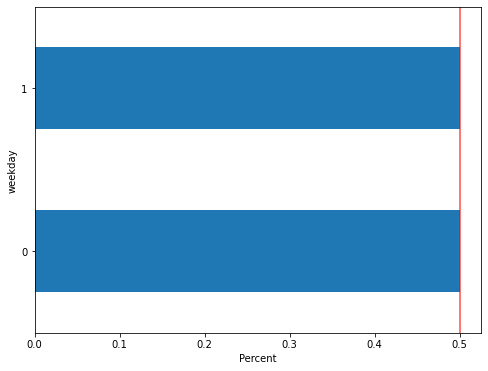

In [79]:
crosstab_plot(df, 'weekday', 'target')

There is no pattern in Joe sessions occuring on weekends vs weekdays.

Visualize the monthly rate of joe and not joe sessions.

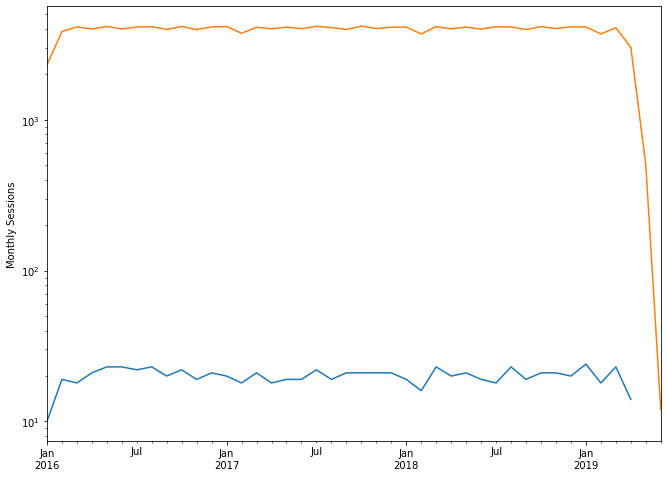

In [80]:
joe_df = df.query('target == 1')
joe_dates = pd.Series(index=joe_df.date.values, data = np.ones(shape=joe_df.shape[0]))
joe_monthly = joe_dates.resample("m").sum()
joe_monthly.plot(figsize=(11, 8))
monthly.plot(figsize=(11, 8))
plt.yscale('log')
plt.ylabel("Monthly Sessions");

The rate of joe sessions exhibitis a little more variation than that of the general population but overall still does not show any major indications of temporal trends.

The percentage of joe sessions for each hour value. Red line indicates general joe session rate.

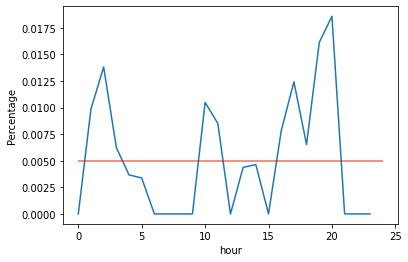

In [81]:
df.groupby("hour").target.mean().plot()
plt.hlines(df.target.mean(),xmin=0, xmax=24, colors="r", alpha = .6)
plt.ylabel("Percentage");

Compared to the general population, joe sessions disproportionately occur around 1-3am, 10am, and 4-8pm.

We can also see that there are nine hour values in which no joe sessions occur and six hour values with at least twice the rate of joe sessions compared to the general population.

### sites vs target

In [82]:
#Derive the average length for joe and non joe sessions
target = df.target
avg_length_by_target = sites_enc.groupby(target).mean().T

In [83]:
avg_length_by_target

target,0,1
0x.tf,0.005848,0.0
139.com,0.006577,0.0
22.cn,0.006935,0.0
247wallst.com,0.006225,0.0
28s06.xyz,0.005810,0.0
...,...,...
zoozoosexporn.com,0.006351,0.0
zradio.org,0.006036,0.0
zscalergov.net,0.008423,0.0
zubuchygri.com,0.007230,0.0


In [84]:
#calculate the difference in average times between joe and non joe sessions
avg_length_by_target["time_diff"] = avg_length_by_target.diff(axis = 1).iloc[:, 1]

In [85]:
avg_length_by_target

target,0,1,time_diff
0x.tf,0.005848,0.0,-0.005848
139.com,0.006577,0.0,-0.006577
22.cn,0.006935,0.0,-0.006935
247wallst.com,0.006225,0.0,-0.006225
28s06.xyz,0.005810,0.0,-0.005810
...,...,...,...
zoozoosexporn.com,0.006351,0.0,-0.006351
zradio.org,0.006036,0.0,-0.006036
zscalergov.net,0.008423,0.0,-0.008423
zubuchygri.com,0.007230,0.0,-0.007230


The top ten sites with the largest difference in time spent between joe and non joe sessions.

In [86]:
avg_length_by_target["time_diff"].nlargest(10)

toptal.com         88.849070
slack.com          87.477299
lenta.ru           87.291891
mail.google.com    86.565634
youtube.com        80.612795
vk.com             68.468800
wikipedia.org       1.152399
joveo.com           1.056087
toolmax.nl          0.899171
gocps.net           0.770063
Name: time_diff, dtype: float64

There are appears to be six sites that joe sessions disproportionately visit compared to the general population.

The top ten sites with the largest difference in time spent between non joe and joe sessions.

In [87]:
avg_length_by_target["time_diff"].nsmallest(10)

live.com                -12.806639
facebook.com            -12.391005
bing.com                -12.227054
akadns.net              -10.877494
googleusercontent.com   -10.484165
vimeo.com               -10.328982
googleapis.com          -10.260930
google.com              -10.058398
aaplimg.com             -10.010063
digicert.com             -9.919899
Name: time_diff, dtype: float64

In [88]:
joe_sites_enc = sites_enc.loc[joe_df.index]

The websites joe sessions have visited

In [89]:
joe_sites = joe_sites_enc.columns[joe_sites_enc.sum()>0]
joe_sites

Index(['adkaora.space', 'adword.ge', 'airbnb.com', 'akadns.net', 'akamai.net',
       'akamaiedge.net', 'amazon.com', 'amazonaws.com', 'app-measurement.com',
       'apple-dns.net', 'apple.com', 'baidu.com', 'bing.com', 'bing.net',
       'booking.com', 'cloudflare.com', 'clubfilm3.xyz', 'digicert.com',
       'doubleclick.net', 'dropr.io', 'ekosport.fr', 'el-f.ru', 'facebook.com',
       'facebook.net', 'fbcdn.net', 'gocps.net', 'google-analytics.com',
       'google.com', 'googleadservices.com', 'googleapis.com',
       'googlesyndication.com', 'googletagmanager.com',
       'googleusercontent.com', 'googlevideo.com', 'gvt1.com', 'gvt2.com',
       'herviewfromhome.com', 'icloud.com', 'im.center', 'imglink.io',
       'instagram.com', 'joveo.com', 'kvnbw.de', 'lencr.org', 'lenta.ru',
       'live.com', 'livingonadime.com', 'mail.google.com', 'microsoft.com',
       'microsoftonline.com', 'msedge.net', 'msn.com', 'myhumatrix.com',
       'netflix.com', 'netflix.net', 'newsinc.com', 'n

The total number:

In [91]:
len(joe_sites)

89

### browser vs OS

I check for redundancy in the features to help me decide whether or not I need to drop any of them.

In [92]:
pd.crosstab(df.browser, df["os"])

os,Debian,MacOS,Ubuntu,Windows 10,Windows 7,Windows 8
browser,,,,,,
Chrome,4978,0,8389,35937,8497,25743
Firefox,2570,0,2747,13589,3169,12367
Internet Explorer,1227,0,595,4815,1164,5832
Safari,0,28381,0,0,0,0


The obvious conclusion here is that it would make sense to drop either `Safari` or `MacOS` after I one hot encode the data.

## Conclusion.

My exploratory analysis yielded important findings about the nature of the data that will be critical in the machine learning modeling process.

What I learned and gleaned from the data:

- Extremely imbalanced class dataset. Joe sessions only account for 0.5% of the data.
- The structure of the sites sessions data necesstitated employing out of the box techniques to handle it.
- `date` and `avg_length` proved to be irrelevant variable when it comes to predicting the target variable.
- `time` is useful in that the `hour` mark showed patterns in the joe sessions.
- `browser`, `os`, `gender`, `location` are likely to be useful features in predicting the target variable.
- From spliting up `locale` we saw that the only software language and country used by joe sessions are Russian.
- I should drop `city` or `country` for the modeling process to reduce redundancy.
- After one hot encoding `os` and `browser` I will drop `Safari` or `MacOS`
- `sites` has the potential be a strong predictor because of the gulf in time spent on few select sites between joe and non joe sessions.

Saving processed datasets

In [93]:
df.to_csv("../data/processed_data.csv")
sites_enc.to_csv("../data/sites_encoded.csv")